#Задание 6: Рекуррентные нейронные сети (RNNs)

In [0]:
!pip3 -qq install torch
!pip3 -qq install bokeh
!pip3 -qq install gensim
!pip3 -qq install nltk
!pip3 -qq install scikit-learn

In [2]:
!nvidia-smi

Sat Jan 18 03:10:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

In [0]:
device = torch.device("cuda:0") 

In [4]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [5]:
!ls

sample_data


In [6]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


In [7]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


In [8]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'ADP', 'CONJ', 'ADJ', 'VERB', 'NOUN', 'ADV', 'DET', 'PRON', 'X', 'PRT', 'NUM', '.'}


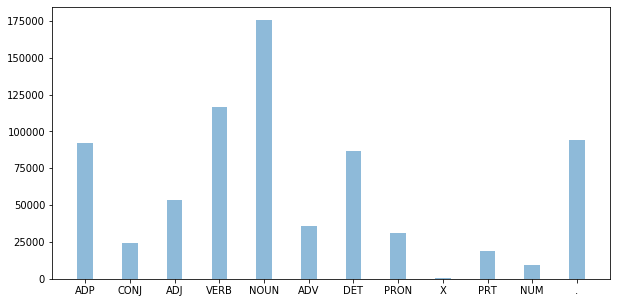

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

#Бейзлайн

In [10]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


In [11]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


In [12]:

trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


#Увеличиваем контекст с рекуррентными сетями

In [0]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [0]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [15]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((32, 4), (32, 4))

In [0]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()

        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)

        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count)
        self.hidden2tag = nn.Linear(lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        embeds = self.word_embeddings(inputs)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [60]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)
model.type(torch.cuda.FloatTensor)
model = model.to(device)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)
x_batch_gpu = X_batch.to(device)
y_batch_gpu = y_batch.to(device)
logits = model(x_batch_gpu)
prediction = torch.argmax(logits, dim=-1)
mask = (y_batch_gpu != 0).float()
correct_samples  = ((prediction == y_batch_gpu).float() * mask).sum().item()
total_samples = mask.sum().item()

accuracy = correct_samples / total_samples
print(accuracy)

0.09782608695652174


In [70]:
loss = nn.CrossEntropyLoss(ignore_index=0).type(torch.cuda.FloatTensor)
loss_value = 0
for ind, row in enumerate(logits):
    loss_value += loss(row, y_batch_gpu[ind])
loss_value = loss_value.item()
print(loss_value)

82.26701354980469


In [0]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                logits = model(X_batch)

                loss = 0
                for ind, row in enumerate(logits):
                    loss += criterion(row, y_batch[ind])
                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                prediction = torch.argmax(logits, dim=-1)
                mask = (y_batch != 0).float()
                cur_correct_count, cur_sum_count = ((prediction == y_batch).float() * mask).sum().item(), mask.sum().item()

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')


def compute_accuracy(model, dataset, batch_size=64):
    model.eval()
    correct = 0
    total = 0
    for i, (X_batch, y_batch) in enumerate(iterate_batches(dataset, batch_size)):
        X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        logits = model(X_batch)
        
        prediction = torch.argmax(logits, dim=-1)
        mask = (y_batch != 0).float()
        correct += ((prediction == y_batch).float() * mask).sum().item()
        total += mask.sum().item()        
        
    return float(correct)/total

In [76]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)
model.type(torch.cuda.FloatTensor)
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0).type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-3)

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50, batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 55.89747, Accuracy = 70.54%: 100%|██████████| 572/572 [00:10<00:00, 53.38it/s]
[1 / 50]   Val: Loss = 55.38466, Accuracy = 80.94%: 100%|██████████| 13/13 [00:00<00:00, 52.08it/s]
[2 / 50] Train: Loss = 25.47732, Accuracy = 85.50%: 100%|██████████| 572/572 [00:10<00:00, 54.30it/s]
[2 / 50]   Val: Loss = 39.13791, Accuracy = 86.52%: 100%|██████████| 13/13 [00:00<00:00, 78.06it/s]
[3 / 50] Train: Loss = 16.95612, Accuracy = 90.26%: 100%|██████████| 572/572 [00:10<00:00, 54.95it/s]
[3 / 50]   Val: Loss = 32.91416, Accuracy = 89.92%: 100%|██████████| 13/13 [00:00<00:00, 77.28it/s]
[4 / 50] Train: Loss = 11.57130, Accuracy = 93.06%: 100%|██████████| 572/572 [00:10<00:00, 53.86it/s]
[4 / 50]   Val: Loss = 28.85817, Accuracy = 91.89%: 100%|██████████| 13/13 [00:00<00:00, 76.04it/s]
[5 / 50] Train: Loss = 8.42459, Accuracy = 94.55%: 100%|██████████| 572/572 [00:10<00:00, 59.56it/s] 
[5 / 50]   Val: Loss = 27.88556, Accuracy = 92.67%: 100%|██████████| 13/13 [00:00<00:00, 7

In [77]:
accuracy =  compute_accuracy(model, (X_test, y_test))
print(f'Test accuracy is {accuracy * 100} %')

Test accuracy is 93.70741800329812 %


#Bidirectional LSTM

In [0]:
class BidirectionalLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count, bidirectional=True)
        self.hidden2tag = nn.Linear(2 * lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        embeds = self.word_embeddings(inputs)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [79]:
model = BidirectionalLSTMTagger(
    lstm_layers_count=2,
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)
model.type(torch.cuda.FloatTensor)
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0).type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=10, batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 10] Train: Loss = 42.71084, Accuracy = 76.69%: 100%|██████████| 572/572 [00:18<00:00, 31.61it/s]
[1 / 10]   Val: Loss = 39.11693, Accuracy = 86.03%: 100%|██████████| 13/13 [00:00<00:00, 32.90it/s]
[2 / 10] Train: Loss = 16.26652, Accuracy = 90.76%: 100%|██████████| 572/572 [00:17<00:00, 33.28it/s]
[2 / 10]   Val: Loss = 30.68741, Accuracy = 90.55%: 100%|██████████| 13/13 [00:00<00:00, 31.99it/s]
[3 / 10] Train: Loss = 9.54407, Accuracy = 94.35%: 100%|██████████| 572/572 [00:17<00:00, 32.24it/s]
[3 / 10]   Val: Loss = 25.39520, Accuracy = 93.08%: 100%|██████████| 13/13 [00:00<00:00, 31.78it/s]
[4 / 10] Train: Loss = 5.75777, Accuracy = 96.20%: 100%|██████████| 572/572 [00:17<00:00, 32.43it/s]
[4 / 10]   Val: Loss = 23.28302, Accuracy = 93.80%: 100%|██████████| 13/13 [00:00<00:00, 31.92it/s]
[5 / 10] Train: Loss = 3.54692, Accuracy = 97.38%: 100%|██████████| 572/572 [00:17<00:00, 32.14it/s]
[5 / 10]   Val: Loss = 25.93545, Accuracy = 94.41%: 100%|██████████| 13/13 [00:00<00:00, 31.8

In [80]:
accuracy =  compute_accuracy(model, (X_test, y_test))
print(f'Test accuracy is {accuracy * 100} %')

Test accuracy is 94.83318357552785 %


#Предобученные эмбеддинги

In [81]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [82]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


In [0]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        
        self.word_embeddings = nn.Embedding.from_pretrained(embeddings)
        self.lstm = nn.LSTM(embeddings.shape[1], 
                             lstm_hidden_dim, 
                             lstm_layers_count, 
                             bidirectional=True)
        self.hidden2tag = nn.Linear(2*lstm_hidden_dim, tagset_size)

    def forward(self, inputs):
        embeds = self.word_embeddings(inputs)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [86]:
model = LSTMTaggerWithPretrainedEmbs(
    lstm_layers_count=2,
    embeddings=torch.FloatTensor(embeddings),
    tagset_size=len(tag2ind)
)
model.type(torch.cuda.FloatTensor)
model = model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=0).type(torch.cuda.FloatTensor)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=10, batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 10] Train: Loss = 43.73999, Accuracy = 78.78%: 100%|██████████| 572/572 [00:15<00:00, 35.84it/s]
[1 / 10]   Val: Loss = 30.65495, Accuracy = 90.05%: 100%|██████████| 13/13 [00:00<00:00, 43.64it/s]
[2 / 10] Train: Loss = 15.10263, Accuracy = 92.09%: 100%|██████████| 572/572 [00:15<00:00, 37.66it/s]
[2 / 10]   Val: Loss = 20.04592, Accuracy = 93.03%: 100%|██████████| 13/13 [00:00<00:00, 53.97it/s]
[3 / 10] Train: Loss = 11.36686, Accuracy = 93.85%: 100%|██████████| 572/572 [00:15<00:00, 36.61it/s]
[3 / 10]   Val: Loss = 17.30680, Accuracy = 94.06%: 100%|██████████| 13/13 [00:00<00:00, 43.06it/s]
[4 / 10] Train: Loss = 9.46754, Accuracy = 94.78%: 100%|██████████| 572/572 [00:15<00:00, 40.24it/s]
[4 / 10]   Val: Loss = 15.63418, Accuracy = 94.87%: 100%|██████████| 13/13 [00:00<00:00, 48.74it/s]
[5 / 10] Train: Loss = 8.36105, Accuracy = 95.22%: 100%|██████████| 572/572 [00:15<00:00, 37.35it/s]
[5 / 10]   Val: Loss = 14.70704, Accuracy = 95.18%: 100%|██████████| 13/13 [00:00<00:00, 50.

In [87]:
accuracy =  compute_accuracy(model, (X_test, y_test))
print(f'Test accuracy is {accuracy * 100} %')

Test accuracy is 95.62569499671221 %
